# Project part A

## Downloading the data

In [4]:
import urllib.request
import urllib.parse
import json
import re
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def getcategorypages(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "list=categorymembers"
    dataformat ="format=json&cmlimit=1000"
    safe_title = "cmtitle=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    categories_list = wikitext_json["query"]["categorymembers"]

    return categories_list

#Todo deep scrape of discussion archives
def getwikidata(title):
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    content = "prop=revisions&rvprop=content&rvslots=*"
    dataformat ="format=json"
    safe_title = "titles=" + urllib.parse.quote_plus(title)

    query = "{}{}&{}&{}&{}".format(baseurl, action, content, safe_title, dataformat)

    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikitext_json = json.loads(wikitext)

    pages_content_list = wikitext_json["query"]["pages"]

    return pages_content_list

def parse_page(page, pages_list, graph):
    if "revisions" in page:
        content = page["revisions"][0]["slots"]["main"]["*"]  # * from rvslots
        title = page["title"]

        # Normalize whitespace
        content = re.sub(r'[\n\t\ ]+', ' ', content)
        # retreive links
        links = re.findall('\[(User:[^/\]\[\|]+)[\]\|]', content) # Previous: '\[([^\]\[\|:]+)[\]\|]'
        filtered_links = np.unique(links)

        archive_number = re.findall('\|\s*counter\s*=\s*([^\|\}\s]+)', content)
        #print(title + " " + str(archive_number[0]))

        #print(filtered_links)

        count = 0
        for link in filtered_links:
            if link not in pages_list:
                graph.add_node(link, page_class="user")
            graph.add_edge(link, title)
            count += 1
        
        # Article word count
        #word_count = len(re.findall('\w+', content.lower()))
        #graph.nodes(data=True)[title]["word_count"] = word_count

        return (title, archive_number)
    return (0,[])


cat_title_l2 = "Category:Wikipedia_level-2_vital_articles"
pages_list_l2 = getcategorypages(cat_title_l2)
titles_list = [r["title"] for r in pages_list_l2]
# Filter only Talk pages
filtered_titles_list = [title for title in titles_list if "Talk:" in title] # Todo might be worth using regex here

# Graph
page_graph = nx.DiGraph()

for page in filtered_titles_list:
    page_graph.add_node(page, page_class="talk")

# Split list because of API limits
split_titles_list = list(chunks(filtered_titles_list, 50))

results = []

for sublist in split_titles_list:
    titlestr = "|".join(sublist)
    pages_content_list = getwikidata(titlestr)
    results += [parse_page(page_content, filtered_titles_list, page_graph) for key, page_content in pages_content_list.items()]

print(results)

filtered_archive_titles_list = []

for result in results:
    if (len(result[1]) > 0):
        for n in range(int(result[1][0])):
            filtered_archive_titles_list.append(result[0] + "/Archive " + str(n))

split_archive_titles_list = list(chunks(filtered_archive_titles_list, 50))

results_archive = []
for sublist in split_archive_titles_list:
    print(sublist)
    titlestr = "|".join(sublist)
    pages_content_list = getwikidata(titlestr)
    results_archive += [parse_page(page_content, filtered_titles_list, page_graph) for key, page_content in pages_content_list.items()]

print(results_archive)

[('Talk:Africa', ['5']), ('Talk:Agriculture', ['4']), ('Talk:Ancient history', ['1']), ('Talk:Animal', ['4']), ('Talk:Architecture', ['1']), ('Talk:Arithmetic', ['1']), ('Talk:Asia', ['3']), ('Talk:Astronomy', ['2']), ('Talk:Atom', ['5']), ('Talk:Biology', ['2']), ('Talk:Book', ['1']), ('Talk:Business', []), ('Talk:Cell (biology)', ['1']), ('Talk:Chemical element', ['2']), ('Talk:Chemistry', ['3']), ('Talk:City', ['1']), ('Talk:Civilization', ['6']), ('Talk:Climate', ['1']), ('Talk:Clothing', ['1']), ('Talk:Communication', []), ('Talk:Computer', ['5']), ('Talk:Country', []), ('Talk:Culture', []), ('Talk:Death', ['4']), ('Talk:Deity', ['2']), ('Talk:Disease', []), ('Talk:Early modern period', []), ('Talk:Ecology', []), ('Talk:Economics', ['8']), ('Talk:Education', []), ('Talk:Electricity', ['3']), ('Talk:Emotion', ['2']), ('Talk:Energy', ['6']), ('Talk:Engineering', ['3']), ('Talk:Entertainment', []), ('Talk:Ethics', ['3']), ('Talk:Ethnicity', ['3']), ('Talk:Europe', ['11']), ('Talk:Evo

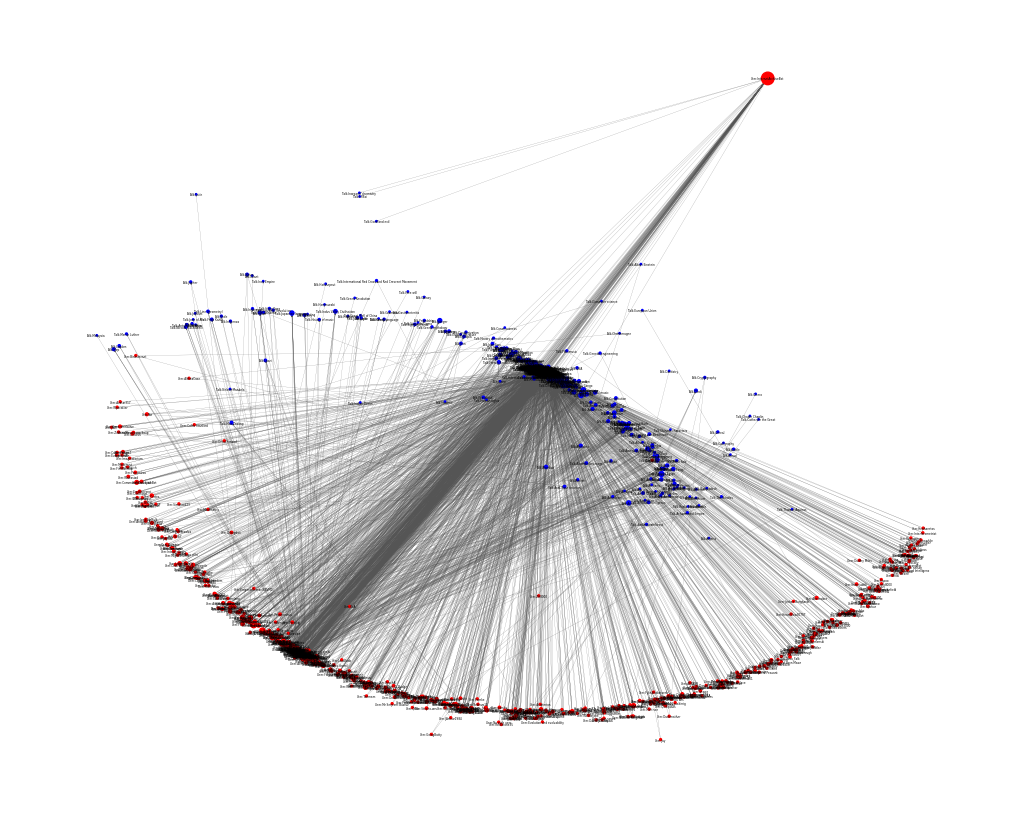

In [9]:
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

graph = page_graph.copy()

# Remove users with only one connection
for node in page_graph.nodes(data=True):
    if node[1]["page_class"] == "user":
        if page_graph.out_degree(node[0]) <= 1:
            graph.remove_node(node[0])

# Remove outliers
cc = nx.weakly_connected_components(graph)
largest_c = max(cc, key=lambda x: len(x))
rsubgraph = nx.subgraph(graph, largest_c)

# Positions (currently unused)
pos = nx.nx_agraph.graphviz_layout(rsubgraph, prog="neato")

# Color and size according to coast and degree
color_talk = "#0000FF"
color_user = "#FF0000"
node_colors = [color_talk if node[1]["page_class"] == "talk" else color_user for node in rsubgraph.nodes(data=True)]
node_sizes = [rsubgraph.degree(node) for node in rsubgraph.nodes]

nx.draw_kamada_kawai(rsubgraph, with_labels=True, font_weight='light', font_size=2, node_size=node_sizes, width=.1, edge_color="#555555", arrowsize=2, node_color=node_colors)

## Preliminary data analysis metrics

> An explanation of the central idea behind your final project (What is the idea? Why is it interesting? Which datasets did you need to explore the idea? How did you download them?)

A walk-through of your preliminary data analysis, addressing:
> - What is the total size of your data? (MB, number of pages, other variables, etc.)
> - What is the network you will be analyzing? (number of nodes? number of links?, degree distributions, what are node attributes?, etc.)
> - What is the text you will be analyzing?
> - How will you tie networks and text together in your paper?